In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
import pandas as pd

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [24]:
def calculate_analytical_Vm_bn2s(params, freqs):
    """
    Calculates analytical soma Vm amplitude

    Args:
        params (dict): A dictionary containing the biophysical parameters.
        freqs (np.ndarray): An array of frequencies (in Hz) to calculate the PSD for.

    Returns:
        tuple: A tuple containing:
            - freqs (np.ndarray): The input frequency array.
            - V_m (np.ndarray): The absolute value of the calculated V_m for the ball-and-two-stick model.
    """
    # --- 1. Extract parameters and convert to SI units ---
    Rm = params['Rm']  # Specific membrane resistance (Ohm * m^2)
    Ri = params['Ri']  # Axial resistivity (Ohm * m)
    Cm = params['Cm']  # Specific membrane capacitance (F / m^2)
    d = params['d']    # Stick diameter (m)
    ds = params['ds']  # Soma diameter (m)
    l1 = params['l1']  # Length of stick 1 (m)
    l2 = params['l2']  # Length of stick 2 (m)
    s_in = params['s_in'] # PSD of white noise input current (A^2 / Hz)

    # --- 2. Calculate derived cable properties ---
    # Angular frequency
    omega = 2 * np.pi * freqs
    # Add a small epsilon to the first frequency to avoid division by zero if f=0
    omega[0] = omega[0] + 1e-9

    # Membrane time constant (s)
    tau_m = Rm * Cm

    # Length constant (m)
    # This is the standard definition from cable theory (e.g., Rall, 1959)
    lambda_ = np.sqrt((d * Rm) / (4 * Ri))

    # Electrotonic lengths (dimensionless)
    L1 = l1 / lambda_
    L2 = l2 / lambda_

    # Dimensionless frequency
    W = omega * tau_m

    # Complex frequency-dependent term q
    q = np.sqrt(1 + 1j * W)

    # --- 3. Calculate admittances (inverse of impedance) ---
    # Admittance of the soma (S)
    Ys = np.pi * ds**2 * (1/Rm) * q**2

    # Infinite-stick admittance (S)
    G_inf = np.pi * d**2 / (4 * Ri * lambda_)
    Y_inf = q * G_inf

    # Total input admittance seen by the soma (S)
    # This is the parallel sum of the soma and the two finite sticks.
    Y_in_total = Ys + Y_inf * (np.tanh(q * L1) + np.tanh(q * L2))

    # --- 4. Calculate the transfer function T_p(f) ---
    # Derived for the ball-and-two-stick model.
    # The numerator represents the difference in dipole moments from the two sticks.
    numerator = lambda_ * G_inf * (1/np.cosh(q * L2) - 1/np.cosh(q * L1))

    # The denominator is the total admittance
    denominator = Y_in_total

    T_p = numerator / denominator
    abs_T_p = np.abs(T_p)

    # Membrane potential from Transfer function
    V_m = 1e3 * abs_T_p # 1e-3 mV/µm = 1e3 mV/m

    results = {'Freq': freqs, 'V_m': V_m}
    df = pd.DataFrame(results)

    return df

In [25]:
def param_sweep_analytic_Vm_2d(params, param_name_1, param_values_1, param_name_2, param_values_2, f0=1000.0):
    """
    Sweeps one parameter and calculates Transfer function at fixed frequency.

    Args:
        params (dict): Biophysical parameters (same as before).
        param_name (str): Name of the parameter to vary (e.g. 'l1', 'l2', 'ds').
        param_values (np.ndarray): Array of values to sweep over.
        f0 (float): Frequency (Hz) at which to evaluate the transfer function.

    Returns:
        dict: A dictionary containing:
            - param_values (np.ndarray): The swept parameter values.
            - V_m (np.ndarray): Analytical Vm at f0 for each param value.
    """
    # Angular frequency
    omega = 2 * np.pi * f0
    if omega == 0:
        omega += 1e-9

    shape = (len(param_values_1), len(param_values_2))
    results = {
        "param_values_1": param_values_1,
        "param_values_2": param_values_2,
        "V_m": np.zeros(shape, dtype=np.float64)
    }

    for i, val1 in enumerate(param_values_1):
        for j, val2 in enumerate(param_values_2):
            # Copy params and replace the swept parameter
            p = params.copy()
            p[param_name_1] = val1
            p[param_name_2] = val2

            # --- Extract parameters ---
            Rm, Ri, Cm = p['Rm'], p['Ri'], p['Cm']
            d, ds, l1, l2, s_in = p['d'], p['ds'], p['l1'], p['l2'], p['s_in']

            # --- Derived properties ---
            tau_m = Rm * Cm
            lambda_ = np.sqrt((d * Rm) / (4 * Ri))
            L1, L2 = l1 / lambda_, l2 / lambda_
            W = omega * tau_m
            q = np.sqrt(1 + 1j * W)

            # Soma admittance
            Ys = np.pi * ds**2 * (1/Rm) * q**2

            # Infinite-stick admittance
            G_inf = np.pi * d**2 / (4 * Ri * lambda_)
            Y_inf = q * G_inf

            # Total admittance
            Y_in_total = Ys + Y_inf * (np.tanh(q * L1) + np.tanh(q * L2))

            # Transfer function numerator/denominator
            numerator = lambda_ * G_inf * (1/np.cosh(q * L2) - 1/np.cosh(q * L1))
            denominator = Y_in_total

            T_p = numerator / denominator

            V_m = 1e3*np.abs(T_p)

            # Store
            results["V_m"][i,j] = V_m

    return results


In [26]:
def plot_len_heatmaps(params, l1_values, l2_values, freqs, pyramidal_lengths, inhibitory_lengths):

    fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=False)

    pyr_l1, pyr_l2 = pyramidal_lengths
    inh_l1, inh_l2 = inhibitory_lengths

    # --- Plot 1: f = 10 Hz ---
    f0_1 = freqs[0]
    results_1 = param_sweep_analytic_Vm_2d(
        params, param_name_1 = 'l1', param_values_1 = l1_values, param_name_2 = 'l2', param_values_2 = l2_values, f0=f0_1
    )

    im1 = axes[0].imshow(
        results_1["V_m"].T,
        extent=[l1_values[0]*1e6, l1_values[-1]*1e6, l2_values[0]*1e6, l2_values[-1]*1e6],
        aspect="auto",
        origin="lower",
        cmap="viridis"
    )

    # Custom colorbar for ax1
    cbar1 = fig.colorbar(im1, ax=axes[0])
    cbar1.ax.set_ylabel("$|\hat{\mathbf{V}}_\mathrm{m}^\mathrm{s}|$ Analytical [mV]")
    fmt1 = ticker.ScalarFormatter(useMathText=True)
    fmt1.set_powerlimits((-2, 2))   # switch to scientific notation if outside [1e-2, 1e2]
    fmt1.set_useOffset(False)
    cbar1.ax.yaxis.set_major_formatter(fmt1)

    offset_text1 = cbar1.ax.yaxis.get_offset_text()
    offset_text1.set_x(2.5)

    axes[0].set_xlabel("Dendrite length $l_1$ [µm]")
    axes[0].set_ylabel("Dendrite length $l_2$ [µm]") 
    axes[0].set_title(f"{f0_1} Hz", fontsize = 10)

    axes[0].scatter(pyr_l1, pyr_l2, color="red", s=8)   # Pyramidal
    axes[0].scatter(inh_l1, inh_l2, color="red", s=8)   # Inhibitory
    axes[0].text(pyr_l1 - 50, pyr_l2 - 80, "Pyramidal \n average", color="red", fontsize=8, va='center')
    axes[0].text(inh_l1 - 50, inh_l2 + 50, "Inhibitory average", color="red", fontsize=8, va='center')

    # --- Plot 2: f = 1000 Hz ---
    f0_2 = freqs[1]
    results_2 = param_sweep_analytic_Vm_2d(
        params, param_name_1 = 'l1', param_values_1 = l1_values, param_name_2 = 'l2', param_values_2 = l2_values, f0=f0_2
    )

    im2 = axes[1].imshow(
        results_2["V_m"].T,
        extent=[l1_values[0]*1e6, l1_values[-1]*1e6, l2_values[0]*1e6, l2_values[-1]*1e6],
        aspect="auto",
        origin="lower",
        cmap="viridis"
    )

    # Keep existing colorbar for ax2, but ensure same formatting
    cbar2 = fig.colorbar(im2, ax=axes[1])
    cbar2.ax.set_ylabel("$|\hat{\mathbf{V}}_\mathrm{m}^\mathrm{s}|$ Analytical [mV]")
    fmt2 = ticker.ScalarFormatter(useMathText=True)
    fmt2.set_powerlimits((-2, 2))
    fmt2.set_useOffset(False)
    cbar2.ax.yaxis.set_major_formatter(fmt2)

    offset_text2 = cbar2.ax.yaxis.get_offset_text()
    offset_text2.set_x(2.5)

    axes[1].set_xlabel("Dendrite length $l_1$ [µm]")
    axes[1].set_ylabel("Dendrite length $l_2$ [µm]") 
    axes[1].set_title(f"{f0_2} Hz", fontsize = 10)

    axes[1].scatter(pyr_l1, pyr_l2, color="red", s=8)   # Pyramidal
    axes[1].scatter(inh_l1, inh_l2, color="red", s=8)   # Inhibitory
    axes[1].text(pyr_l1 - 50, pyr_l2 - 80, "Pyramidal \n average", color="red", fontsize=8, va='center')
    axes[1].text(inh_l1 - 50, inh_l2 + 50, "Inhibitory average", color="red", fontsize=8, va='center')

    axes[0].text(-0.3, 1.10, 'A', transform=axes[0].transAxes, fontsize=12, fontweight='bold')
    axes[1].text(-0.3, 1.10, 'B', transform=axes[1].transAxes, fontsize=12, fontweight='bold')

    # fig.suptitle('Transfer function $|T_p^s|$')

    plt.tight_layout()
    plt.savefig('/Users/susannedahle/Documents/Master/Code/fig_pdfs/fig10.pdf')
    plt.show()

<>:24: SyntaxWarning: invalid escape sequence '\h'
<>:58: SyntaxWarning: invalid escape sequence '\h'
<>:24: SyntaxWarning: invalid escape sequence '\h'
<>:58: SyntaxWarning: invalid escape sequence '\h'
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_23661/3650822900.py:24: SyntaxWarning: invalid escape sequence '\h'
  cbar1.ax.set_ylabel("$|\hat{\mathbf{V}}_\mathrm{m}^\mathrm{s}|$ Analytical [mV]")
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_23661/3650822900.py:58: SyntaxWarning: invalid escape sequence '\h'
  cbar2.ax.set_ylabel("$|\hat{\mathbf{V}}_\mathrm{m}^\mathrm{s}|$ Analytical [mV]")


In [27]:
# Load vmem simulation data to find average lengths of neocortical neurons
base_dir = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/vmem_data_neo' 

vmem_amp_file_paths = [
    os.path.join(base_dir, f'vmem_amp_data_neo_Ez_{i}.npy')
    for i in range(16)
]

vmem_amp_data_list = [
    np.load(path, allow_pickle=True).item()
    for path in vmem_amp_file_paths
]
vmem_amp_data = {}
for data in vmem_amp_data_list:
    vmem_amp_data.update(data)

properties = ['total_len', 'upper_z_endpoint',  'bottom_z_endpoint']

data = {prop: {'PC': [], 'SS': [], 'Inhibitory': []} for prop in properties}

for cell, values in vmem_amp_data.items():
    for prop in properties:
        if 'PC' in cell or 'SP' in cell:
            data[prop]['PC'].append(values[prop])
        elif 'SS' in cell:
            data[prop]['SS'].append(values[prop])
        else:
            data[prop]['Inhibitory'].append(values[prop])

table_data = []

for i, prop in enumerate(properties):
    means = {
        "Property": prop,
        "Pyramidal mean": np.mean(data[prop]['PC']) if data[prop]['PC'] else np.nan,
        "Pyramidal median": np.median(data[prop]['PC']) if data[prop]['PC'] else np.nan,
        #"Spiny Stellate": np.mean(data[prop]['SS']) if data[prop]['SS'] else np.nan,
        "Inhibitory mean": np.mean(data[prop]['Inhibitory']) if data[prop]['Inhibitory'] else np.nan,
        "Inhibitory median": np.median(data[prop]['Inhibitory']) if data[prop]['Inhibitory'] else np.nan
    }
    table_data.append(means)

df = pd.DataFrame(table_data)
pd.set_option("display.precision", 2)
display(df)

# Extract average lengths (in meters)
pyramidal_l1 = df.loc[df["Property"] == "upper_z_endpoint", "Pyramidal mean"].values[0]
pyramidal_l2 = abs(df.loc[df["Property"] == "bottom_z_endpoint", "Pyramidal mean"].values[0])

inhibitory_l1 = df.loc[df["Property"] == "upper_z_endpoint", "Inhibitory mean"].values[0]
inhibitory_l2 = abs(df.loc[df["Property"] == "bottom_z_endpoint", "Inhibitory mean"].values[0])


,Property,Pyramidal mean,Pyramidal median,Inhibitory mean,Inhibitory median
0,total_len,1042.08,1039.25,501.35,469.77
1,upper_z_endpoint,787.18,860.42,220.90,188.03
2,bottom_z_endpoint,-254.91,-212.51,-280.45,-248.44


In [28]:
standard_neuron_parameters = {
    'Rm': 3.0,          # Ohm * m^2
    'Ri': 1.5,          # Ohm * m
    'Cm': 0.01,         # F / m^2
    'd': 2e-6,          # 2 µm -> m
    'ds': 10e-6,        # 20 µm -> m
    'l1': 670e-6,       # 670 µm -> m (Longer stick)
    'l2': 330e-6,       # 330 µm -> m (Shorter stick)
    's_in': (1e-15)**2  # 1 fA^2/Hz -> A^2/Hz
}

neuron_parameters = standard_neuron_parameters.copy()
l1_values = np.linspace(50e-6, 1000e-6, 100)
l2_values = np.linspace(50e-6, 1000e-6, 100)
frequencies_to_plot = [10, 1000]

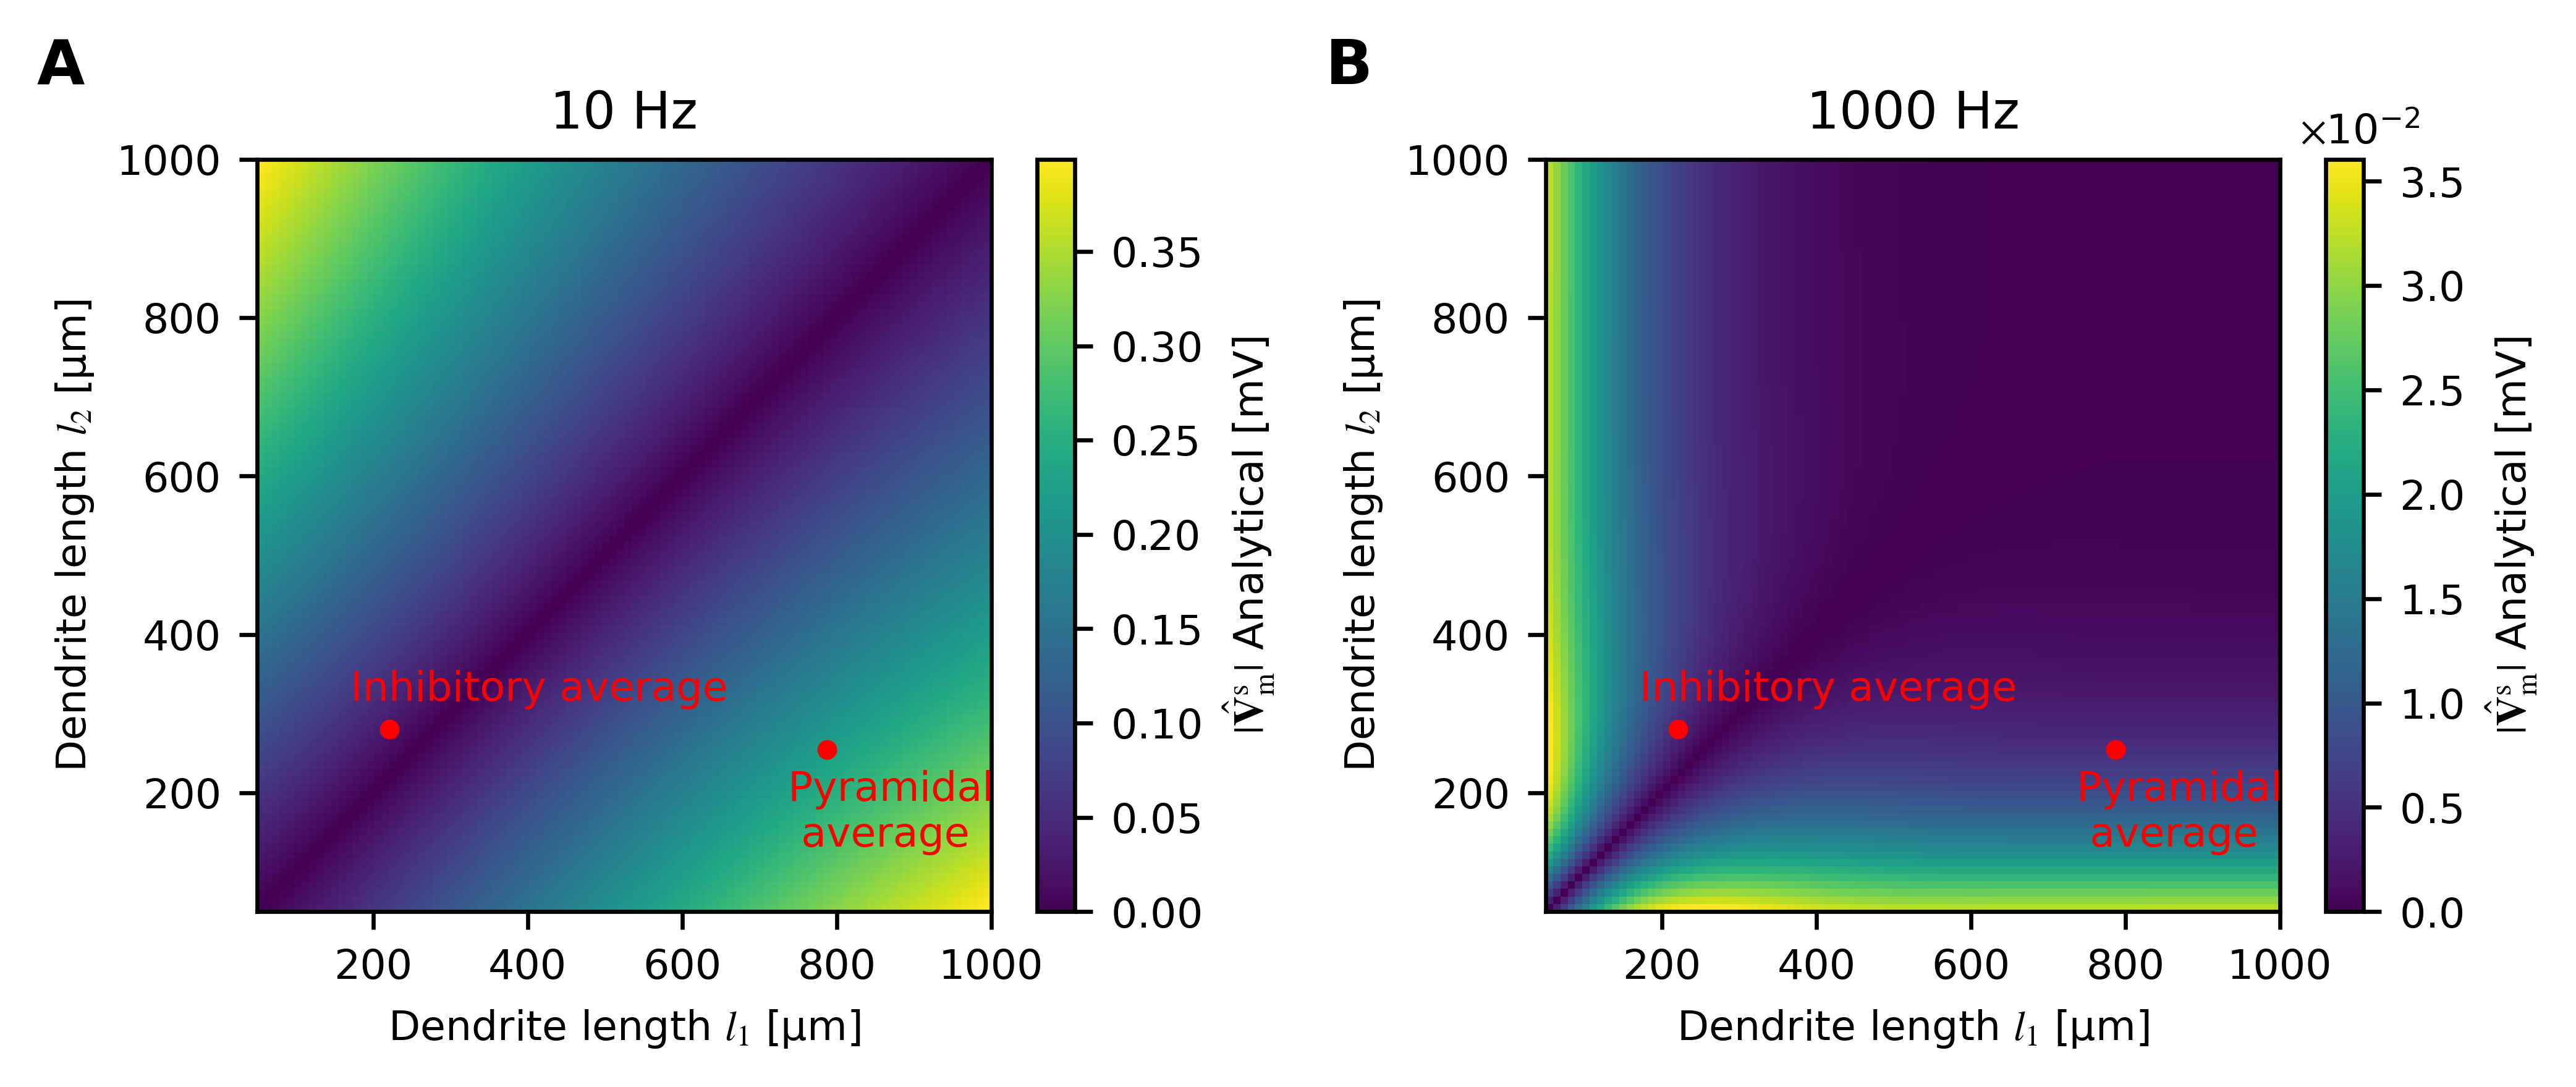

In [35]:
plot_len_heatmaps(
    params=neuron_parameters, 
    l1_values=l1_values,
    l2_values=l2_values,
    freqs=frequencies_to_plot,
    pyramidal_lengths=(pyramidal_l1, pyramidal_l2),
    inhibitory_lengths=(inhibitory_l1, inhibitory_l2)
)

In [30]:
pyramidal_cells_parameters = standard_neuron_parameters.copy()
pyramidal_cells_parameters['l1'] = pyramidal_l1*1e-6
pyramidal_cells_parameters['l2'] = pyramidal_l2*1e-6
calculate_analytical_Vm_bn2s(pyramidal_cells_parameters, freqs=np.array(frequencies_to_plot))

,Freq,V_m
0,10,2.20e-01
1,1000,4.80e-03


In [31]:
inhibitory_neurons_parameters = standard_neuron_parameters.copy()
inhibitory_neurons_parameters['l1'] = inhibitory_l1*1e-6
inhibitory_neurons_parameters['l2'] = inhibitory_l2*1e-6
calculate_analytical_Vm_bn2s(inhibitory_neurons_parameters, freqs=np.array(frequencies_to_plot))

,Freq,V_m
0,10,2.62e-02
1,1000,4.11e-03


In [34]:
4.80e-03

0.0048